# Alphalens Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## Linear Regression

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001839
                           AAPL     -0.001534
                           ABBV      0.001316
                           AGN       0.002175
                           AIG      -0.000336
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 257 entries, AAL to YUM
dtypes: float64(257)
memory usage: 2.0 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.046824,0.008700,-0.003150,0.004048,14982,20.231183
2,-0.015561,0.010754,-0.000985,0.003357,14877,20.089394
3,-0.013413,0.012631,0.000134,0.003347,14336,19.358846
4,-0.011913,0.014850,0.001203,0.003457,14877,20.089394
5,-0.010072,0.038540,0.003289,0.004285,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.033,0.020,0.009,0.005
beta,-0.012,-0.080,-0.058,0.019
Mean Period Wise Return Top Quantile (bps),1.540,0.698,-0.073,0.209
Mean Period Wise Return Bottom Quantile (bps),-2.804,-0.755,-0.532,-0.678
Mean Period Wise Spread (bps),4.344,1.481,0.477,0.877


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.013,0.016
IC Std.,0.181,0.168,0.169,0.157
Risk-Adjusted IC,0.112,0.085,0.079,0.101
t-stat(IC),3.064,2.325,2.161,2.752
p-value(IC),0.002,0.020,0.031,0.006
IC Skew,0.015,-0.025,-0.050,-0.062
IC Kurtosis,-0.138,-0.182,-0.143,-0.278


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.297,0.520,0.621,0.728
Quantile 2 Mean Turnover,0.517,0.707,0.761,0.788
Quantile 3 Mean Turnover,0.570,0.738,0.779,0.808
Quantile 4 Mean Turnover,0.515,0.705,0.755,0.783
Quantile 5 Mean Turnover,0.302,0.536,0.645,0.745


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.818,0.542,0.386,0.238


<Figure size 432x288 with 0 Axes>

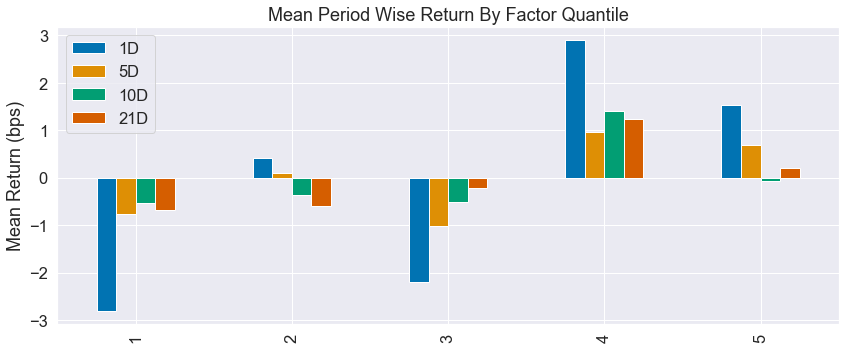

In [13]:
create_summary_tear_sheet(lr_factor_data);

## Ridge Regression

In [14]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001948
                           AAPL     -0.001526
                           ABBV      0.001099
                           AGN       0.001914
                           AIG      -0.000462
dtype: float64

In [16]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.035996,0.009161,-0.003350,0.003619,14982,20.231183
2,-0.013073,0.011246,-0.001328,0.003059,14877,20.089394
3,-0.010553,0.012706,-0.000268,0.003090,14336,19.358846
4,-0.009280,0.015166,0.000742,0.003224,14877,20.089394
5,-0.007696,0.038573,0.002683,0.004058,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.033,0.023,0.013,0.009
beta,-0.010,-0.082,-0.059,0.022
Mean Period Wise Return Top Quantile (bps),1.391,0.474,-0.177,0.101
Mean Period Wise Return Bottom Quantile (bps),-2.657,-1.361,-0.954,-1.062
Mean Period Wise Spread (bps),4.048,1.861,0.795,1.151


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.015,0.014,0.015
IC Std.,0.181,0.170,0.171,0.158
Risk-Adjusted IC,0.113,0.088,0.081,0.096
t-stat(IC),3.085,2.418,2.224,2.634
p-value(IC),0.002,0.016,0.026,0.009
IC Skew,0.008,-0.022,-0.062,-0.063
IC Kurtosis,-0.138,-0.172,-0.126,-0.268


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.294,0.513,0.617,0.723
Quantile 2 Mean Turnover,0.507,0.699,0.756,0.788
Quantile 3 Mean Turnover,0.563,0.734,0.777,0.805
Quantile 4 Mean Turnover,0.511,0.698,0.751,0.785
Quantile 5 Mean Turnover,0.300,0.529,0.640,0.743


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.822,0.56,0.401,0.247


<Figure size 432x288 with 0 Axes>

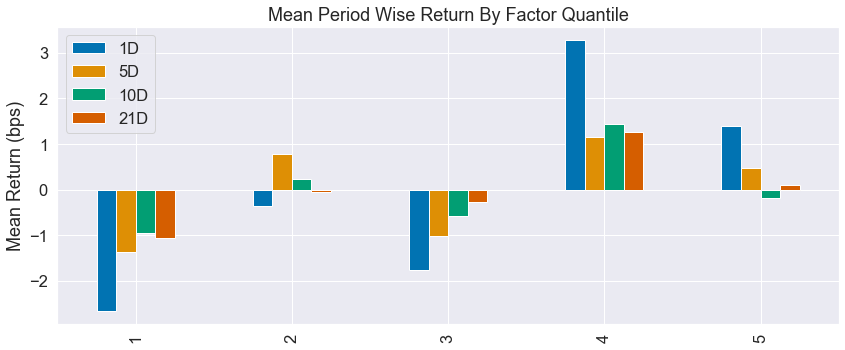

In [17]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [18]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001875
                           AAPL     -0.001646
                           ABBV      0.001164
                           AGN       0.001919
                           AIG      -0.000529
dtype: float64

In [20]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74054 entries, (Timestamp('2014-12-09 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2017-11-29 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               74054 non-null  float64
 1   5D               74054 non-null  float64
 2   10D              74054 non-null  float64
 3   21D              74054 non-null  float64
 4   factor           74054 non-null  float64
 5   factor_quantile  74054 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.044249,0.009401,-0.003446,0.003807,14982,20.231183
2,-0.013901,0.011329,-0.001354,0.003222,14877,20.089394
3,-0.012216,0.013095,-0.000262,0.003277,14336,19.358846
4,-0.010771,0.015355,0.000777,0.003429,14877,20.089394
5,-0.008964,0.038336,0.002798,0.004332,14982,20.231183


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.034,0.022,0.011,0.007
beta,-0.012,-0.080,-0.056,0.021
Mean Period Wise Return Top Quantile (bps),1.912,0.684,-0.084,0.199
Mean Period Wise Return Bottom Quantile (bps),-2.733,-0.906,-0.729,-0.904
Mean Period Wise Spread (bps),4.645,1.618,0.659,1.090


Information Analysis


,1D,5D,10D,21D
IC Mean,0.021,0.015,0.013,0.016
IC Std.,0.182,0.169,0.171,0.157
Risk-Adjusted IC,0.113,0.086,0.077,0.100
t-stat(IC),3.092,2.351,2.106,2.739
p-value(IC),0.002,0.019,0.036,0.006
IC Skew,0.011,-0.017,-0.052,-0.057
IC Kurtosis,-0.152,-0.187,-0.150,-0.300


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.296,0.519,0.619,0.727
Quantile 2 Mean Turnover,0.512,0.703,0.757,0.791
Quantile 3 Mean Turnover,0.566,0.734,0.781,0.806
Quantile 4 Mean Turnover,0.509,0.698,0.753,0.783
Quantile 5 Mean Turnover,0.301,0.534,0.643,0.745


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.82,0.548,0.392,0.239


<Figure size 432x288 with 0 Axes>

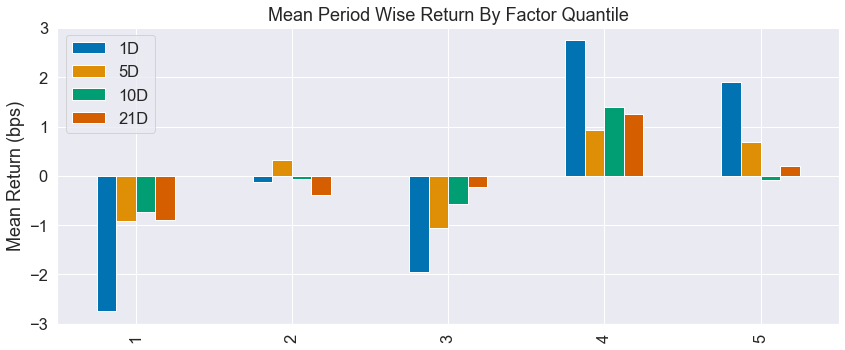

In [21]:
create_summary_tear_sheet(lasso_factor_data);